In [31]:
#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'textblob'

In [32]:
df=pd.read_csv(r"C:\Users\alnis\Downloads\7817_1.csv")
df

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 263: invalid start byte

In [37]:
# It seems there is a decoding issue with the CSV file. Let's try to load it with a different encoding.
# Using ISO-8859-1 (Latin-1) encoding to handle possible special characters.
df = pd.read_csv(r"C:\Users\alnis\Downloads\Amazon_Product Reviews_Dataset_Project 2 (1).csv", encoding='ISO-8859-1')

# Display the first few rows and the columns of the dataset
df.head(), df.columns

(       reviewerID        asin  reviewerName helpful  \
 0  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]   
 1  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]   
 2  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]   
 3   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]   
 4  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   
 
                                           reviewText  overall  \
 0                                         No issues.      4.0   
 1  Purchased this for my device, it worked as adv...      5.0   
 2  it works as expected. I should have sprung for...      4.0   
 3  This think has worked out great.Had a diff. br...      5.0   
 4  Bought it with Retail Packaging, arrived legit...      5.0   
 
                                   summary  unixReviewTime  reviewTime  \
 0                              Four Stars      1406073600  2014-07-23   
 1                           MOAR SPACE!!!      1382659200  2013-10-25   
 2               nothing to really say....

# Dataset Details

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB


## Preprocessing and cleaning

> We got to do lot of preprocessing before sending the reviews to the model. Let's go step by step.

> > Handling NaN values

In [39]:
#Creating a copy
process_reviews=df.copy()

#Checking for null values
process_reviews.isnull().sum()

reviewerID        0
asin              0
reviewerName      1
helpful           0
reviewText        1
overall           0
summary           0
unixReviewTime    0
reviewTime        0
day_diff          0
helpful_yes       0
total_vote        0
dtype: int64

In [40]:
process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')
process_reviews['reviewerName']=process_reviews['reviewerName'].fillna('Zz')

# Concatenating review text and summary

> Let's combine review text and summary column. The sentiments won't be contradicting in nature.

In [41]:
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)
process_reviews.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,reviews
0,A3SBTW3WS4IQSN,B007WTAJTO,Zz,"[0, 0]",4.0,1406073600,2014-07-23,138,0,0,No issues.Four Stars
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",5.0,1382659200,2013-10-25,409,0,0,"Purchased this for my device, it worked as adv..."
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",4.0,1356220800,2012-12-23,715,0,0,it works as expected. I should have sprung for...
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",5.0,1384992000,2013-11-21,382,0,0,This think has worked out great.Had a diff. br...
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",5.0,1373673600,2013-07-13,513,0,0,"Bought it with Retail Packaging, arrived legit..."


# Creating 'sentiment' column

> This is an important preprocessing phase, we are deciding the outcome column (sentiment of review) based on the overall score. If the score is greater than 3, we take that as positive and if the value is less than 3 it is negative If it is equal to 3, we take that as neutral sentiment

In [42]:
#Figuring out the distribution of categories
process_reviews['overall'].value_counts()

overall
5.0    3922
4.0     527
1.0     244
3.0     142
2.0      80
Name: count, dtype: int64

In [56]:
def f(row):
    # This function returns sentiment value based on the overall ratings from the user
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val


In [57]:
#Applying the function in our new column
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,reviews,sentiment
0,A3SBTW3WS4IQSN,B007WTAJTO,Zz,"[0, 0]",4.0,1406073600,2014-07-23,138,0,0,No issues.Four Stars,Positive
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",5.0,1382659200,2013-10-25,409,0,0,"Purchased this for my device, it worked as adv...",Positive
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",4.0,1356220800,2012-12-23,715,0,0,it works as expected. I should have sprung for...,Positive
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",5.0,1384992000,2013-11-21,382,0,0,This think has worked out great.Had a diff. br...,Positive
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",5.0,1373673600,2013-07-13,513,0,0,"Bought it with Retail Packaging, arrived legit...",Positive


In [58]:
process_reviews['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [59]:
process_reviews['sentiment'].value_counts()

sentiment
Positive    4449
Negative     324
Neutral      142
Name: count, dtype: int64

# Handling time column

  > Here we have an unusual review time column which has date and year, once we split both we will split the date further into month and date.

In [60]:
# new data frame which has date and year
new = process_reviews["reviewTime"].str.split("-", n = 1, expand = True) 
  
# making separate date column from new data frame 
process_reviews["year"]= new[0] 
  
# making separate year column from new data frame 
process_reviews["date"]= new[1] 

process_reviews=process_reviews.drop(['reviewTime'], axis=1)
process_reviews.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,day_diff,helpful_yes,total_vote,reviews,sentiment,year,date
0,A3SBTW3WS4IQSN,B007WTAJTO,Zz,"[0, 0]",4.0,1406073600,138,0,0,No issues.Four Stars,Positive,2014,07-23
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",5.0,1382659200,409,0,0,"Purchased this for my device, it worked as adv...",Positive,2013,10-25
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",4.0,1356220800,715,0,0,it works as expected. I should have sprung for...,Positive,2012,12-23
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",5.0,1384992000,382,0,0,This think has worked out great.Had a diff. br...,Positive,2013,11-21
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",5.0,1373673600,513,0,0,"Bought it with Retail Packaging, arrived legit...",Positive,2013,07-13


In [61]:
# Splitting the date 
new1 = process_reviews["date"].str.split("-", n = 1, expand = True) 
  
# adding month to the main dataset 
process_reviews["month"]= new1[0] 
  
# adding day to the main dataset 
process_reviews["day"]= new1[1] 

process_reviews=process_reviews.drop(['date'], axis=1)
process_reviews.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,day_diff,helpful_yes,total_vote,reviews,sentiment,year,month,day
0,A3SBTW3WS4IQSN,B007WTAJTO,Zz,"[0, 0]",4.0,1406073600,138,0,0,No issues.Four Stars,Positive,2014,07,23
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",5.0,1382659200,409,0,0,"Purchased this for my device, it worked as adv...",Positive,2013,10,25
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",4.0,1356220800,715,0,0,it works as expected. I should have sprung for...,Positive,2012,12,23
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",5.0,1384992000,382,0,0,This think has worked out great.Had a diff. br...,Positive,2013,11,21
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",5.0,1373673600,513,0,0,"Bought it with Retail Packaging, arrived legit...",Positive,2013,07,13


# Finding the helpfulness of the review
>  From the main dataframe we can see the helpful feature with values in list [a,b] format. It says that a out of b people found that review helpful. But with that format, it could not add value to the machine learning model and it will be difficult to decrypt the meaning for the machine. So I have planned to create helpful_rate feature which returns a/b value from [a,b]. The following codeblock contains the complete processing step. I have added comments on what's happenening in each code. Unhide to see the code

In [62]:
# Splitting the dataset based on comma and square bracket 
new1 = process_reviews["helpful"].str.split(",", n = 1, expand = True)
new2 = new1[0].str.split("[", n = 1, expand = True)
new3 = new1[1].str.split("]", n = 1, expand = True)

#Resetting the index
new2.reset_index(drop=True, inplace=True)
new3.reset_index(drop=True, inplace=True)

#Dropping empty columns due to splitting 
new2=new2.drop([0], axis=1)
new3=new3.drop([1], axis=1)

#Concatenating the splitted columns
helpful=pd.concat([new2, new3], axis=1)


# I found few spaces in new3, so it is better to strip all the values to find the rate
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

#Applying the function
helpful= trim_all_columns(helpful)

#Converting into integer types
helpful[0]=helpful[0].astype(str).astype(int)
helpful[1]=helpful[1].astype(str).astype(int)

#Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those errors
try:
  helpful['result'] = helpful[1]/helpful[0]
except ZeroDivisionError:
  helpful['result']=0

#Filling the NaN values(created due to dividing) with 0
helpful['result'] = helpful['result'].fillna(0)

#Rounding of the results to two decimal places
helpful['result']=helpful['result'].round(2) 

#Attaching the results to a new column of the main dataframe
process_reviews['helpful_rate']=helpful['result']

#dropping the helpful column from main dataframe
process_reviews=process_reviews.drop(['helpful'], axis=1)

C:\Users\alnis\AppData\Local\Temp\ipykernel_18488\222074792.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(trim_strings)


In [63]:
process_reviews.head()

,reviewerID,asin,reviewerName,overall,unixReviewTime,day_diff,helpful_yes,total_vote,reviews,sentiment,year,month,day,helpful_rate
0,A3SBTW3WS4IQSN,B007WTAJTO,Zz,4.0,1406073600,138,0,0,No issues.Four Stars,Positive,2014,07,23,0.0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,5.0,1382659200,409,0,0,"Purchased this for my device, it worked as adv...",Positive,2013,10,25,0.0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,4.0,1356220800,715,0,0,it works as expected. I should have sprung for...,Positive,2012,12,23,0.0
3,A3H99DFEG68SR,B007WTAJTO,1m2,5.0,1384992000,382,0,0,This think has worked out great.Had a diff. br...,Positive,2013,11,21,0.0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,5.0,1373673600,513,0,0,"Bought it with Retail Packaging, arrived legit...",Positive,2013,07,13,0.0


> We have successfully created the helpful_rate column through processing steps. Let's look at the values


In [64]:
process_reviews['helpful_rate'].value_counts()

helpful_rate
0.00    4502
1.00     314
0.50      47
0.33       9
0.75       9
0.80       4
0.60       4
0.67       4
0.88       3
0.86       3
0.71       2
0.85       1
0.14       1
0.31       1
0.78       1
0.93       1
0.81       1
0.95       1
0.07       1
0.22       1
0.97       1
0.20       1
0.83       1
0.79       1
0.92       1
Name: count, dtype: int64

> > 0.00 indicates that the review hasn't been much helpful and 1.00 indicates that the review has been very helpful


Review text-Punctuation Cleaning

> Let's begin our text processing by removing the punctuations

In [65]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['reviewerName','unixReviewTime'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [66]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [67]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

,reviewerID,asin,overall,day_diff,helpful_yes,total_vote,reviews,sentiment,year,month,day,helpful_rate
0,A3SBTW3WS4IQSN,B007WTAJTO,4.0,138,0,0,no issuesfour stars,Positive,2014,07,23,0.0
1,A18K1ODH1I2MVB,B007WTAJTO,5.0,409,0,0,purchased this for my device it worked as adve...,Positive,2013,10,25,0.0
2,A2FII3I2MBMUIA,B007WTAJTO,4.0,715,0,0,it works as expected i should have sprung for ...,Positive,2012,12,23,0.0
3,A3H99DFEG68SR,B007WTAJTO,5.0,382,0,0,this think has worked out greathad a diff bran...,Positive,2013,11,21,0.0
4,A375ZM4U047O79,B007WTAJTO,5.0,513,0,0,bought it with retail packaging arrived legit ...,Positive,2013,07,13,0.0


> > We have removed all punctuation in our review column

# Review text-Stop words

> Coming to stop words, general nltk stop words contains words like not,hasn't,would'nt which actually conveys a negative sentiment. If we remove that it will end up contradicting the target variable(sentiment). So I have curated the stop words which doesn't have any negative sentiment or any negative alternatives.

In [68]:
stop_words=STOPWORDS
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

In [69]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

,reviewerID,asin,overall,day_diff,helpful_yes,total_vote,reviews,sentiment,year,month,day,helpful_rate
0,A3SBTW3WS4IQSN,B007WTAJTO,4.0,138,0,0,issuesfour stars,Positive,2014,07,23,0.0
1,A18K1ODH1I2MVB,B007WTAJTO,5.0,409,0,0,purchased device worked advertised never much ...,Positive,2013,10,25,0.0
2,A2FII3I2MBMUIA,B007WTAJTO,4.0,715,0,0,works expected sprung higher capacity think ma...,Positive,2012,12,23,0.0
3,A3H99DFEG68SR,B007WTAJTO,5.0,382,0,0,think worked greathad diff bran card went sout...,Positive,2013,11,21,0.0
4,A375ZM4U047O79,B007WTAJTO,5.0,513,0,0,bought retail packaging arrived legit orange e...,Positive,2013,07,13,0.0


>  > We have removed all the stop words in the review column

### Story Generation and Visualization from reviews

- Sentiments vs Helpful rate

> First lets look whether there any relationship between sentiment of review and helpfulness of it

In [72]:
pd.DataFrame(process_reviews.groupby('sentiment')['helpful_rate'].mean())

,helpful_rate
sentiment,
Negative,0.225710
Neutral,0.108732
Positive,0.063461


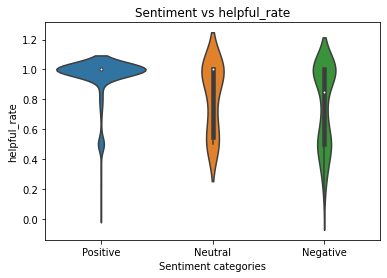

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(process_reviews, columns = ['sentiment', 'helpful_rate'])
senti_help = senti_help[senti_help['helpful_rate'] != 0.00] 

#Plotting phase
sns.violinplot( x=senti_help["sentiment"], y=senti_help["helpful_rate"])
plt.title('Sentiment vs helpful_rate')
plt.xlabel('Sentiment categories')
plt.ylabel('helpful_rate')
plt.show()

# - Year vs Sentiment count

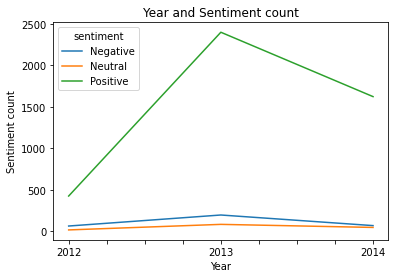

In [74]:
process_reviews.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

Day of month vs Reviews count

> >Let's check if there are any relationship between reviews and day of month

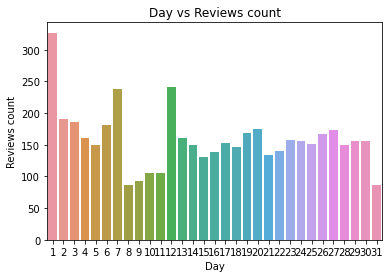

In [75]:
#Creating a dataframe
day=pd.DataFrame(process_reviews.groupby('day')['reviews'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

#Plotting the graph
sns.barplot(x="day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

# Creating few more features for text analysis

>  Now, let's create polarity, review length and word count

>  > Polarity: We use Textblob for for figuring out the rate of sentiment . It is between [-1,1] where -1 is negative and 1 is positive polarity

>  > Review length: length of the review which includes each letters and spaces

>  > Word length: This measures how many words are there in review

In [78]:
from textblob import TextBlob
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))

In [79]:
process_reviews.head()

,reviewerID,asin,overall,day_diff,helpful_yes,total_vote,reviews,sentiment,year,month,day,helpful_rate,polarity,review_len,word_count
0,A3SBTW3WS4IQSN,B007WTAJTO,4.0,138,0,0,issuesfour stars,Positive,2014,07,23,0.0,0.000000,16,2
1,A18K1ODH1I2MVB,B007WTAJTO,5.0,409,0,0,purchased device worked advertised never much ...,Positive,2013,10,25,0.0,-0.100000,98,14
2,A2FII3I2MBMUIA,B007WTAJTO,4.0,715,0,0,works expected sprung higher capacity think ma...,Positive,2012,12,23,0.0,0.143333,121,17
3,A3H99DFEG68SR,B007WTAJTO,5.0,382,0,0,think worked greathad diff bran card went sout...,Positive,2013,11,21,0.0,0.250000,169,25
4,A375ZM4U047O79,B007WTAJTO,5.0,513,0,0,bought retail packaging arrived legit orange e...,Positive,2013,07,13,0.0,0.386667,226,34


In [82]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Sentiment polarity distribution

> > Let's look at our polarity distribution

In [83]:
process_reviews['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')
plt.show()

# Review Rating Distribution

> >Let's check out how overall ratings are distributed

In [84]:
process_reviews['overall'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',
    title='Review Rating Distribution')
plt.show()

# Review Text Length Distribution

> > Let's check out the length of review text

In [86]:
process_reviews['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

# Review Text Word Count Distribution

> > Let's check out the word count of review text

In [87]:
process_reviews['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

# N-gram analysis

> > Welcome to the deep text analysis. Here we will be using ngrams to analyse the text, based on it's sentiment

# Monogram analysis

> > Here we will plot most frequent one word in reviews based on sentiments

In [88]:
from collections import defaultdict
import plotly.graph_objs as go
!pip install plotly
from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.graph_objects as go
# from plotly.plotly import iplot

#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

    

# - Bigram analysis
> > Here we will plot most frequent two words in reviews based on sentiments

In [90]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')


# Creating two subplots
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
py.iplot(fig, filename='word-plots')


# - Trigram analysis

> >Here we will plot most frequent three words in reviews based on sentiments

In [92]:
## Get the bar chart from positive reviews ##
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')


# Creating two subplots
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')


#  Wordcloud

# Wordcloud-Positive reviews

> > Let's look at the word cloud of positive reviews

In [93]:
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

ValueError: Only supported for TrueType fonts

# - Wordcloud-Neutral reviews

> > Let's look at the word cloud of neutral reviews

In [94]:
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

ValueError: Only supported for TrueType fonts

# - Wordcloud-Negative reviews

> > Let's look at the word cloud of negative reviews

In [95]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

ValueError: Only supported for TrueType fonts

# Extracting Features from Cleaned reviews

>  Before we build the model for our sentiment analysis, it is required to convert the review texts into vector formation as computer cannot understand words and their sentiment. In this project, we are going to use TF-TDF method to convert the texts

In [96]:
process_reviews['sentiment'].unique() 

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [97]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
  
process_reviews['sentiment'].unique() 

array([2, 1, 0])

In [98]:
process_reviews['sentiment'].value_counts()

sentiment
2    4449
0     324
1     142
Name: count, dtype: int64

In [99]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

,reviews
0,issuesfour stars
1,purchased device worked advertised never much ...
2,works expected sprung higher capacity think ma...
3,think worked greathad diff bran card went sout...
4,bought retail packaging arrived legit orange e...


In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from collections import Counter
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)  

> TFIDF(Term Frequency — Inverse Document Frequency)

> > TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining.

> > Here we are splitting as bigram (two words) and consider their combined weight.Also we are taking only the top 5000 words from the reviews.

In [101]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [102]:
X.shape

(4915, 5000)

In [103]:
#Getting the target variable(encoded)
y=process_reviews['sentiment']

> Handling Imbalance target feature-SMOTE

>  >In our target feature, we noticed that we got a lot of positive sentiments compared to negative and neutral. So it is crucial to balanced the classes in such situatio. Here I use SMOTE(Synthetic Minority Oversampling Technique) to balance out the imbalanced dataset problem.It aims to balance class distribution by randomly increasing minority class examples by replicating them.

>  > SMOTE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [106]:
from imblearn.over_sampling import SMOTE
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 4449, 0: 324, 1: 142})
Resampled dataset shape Counter({2: 4449, 1: 4449, 0: 4449})


>Train-test split(75:25)

> > Using train test split function we are splitting the dataset into 75:25 ratio for train and test set respectively.

In [107]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

### Model Building: Sentiment Analysis

> > As we have successfully processed the text data, not it is just a normal machine learning problem. Where from the sparse matrix we predict the classes in target feature.

In [108]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
    plt.ylabel('True label')


    plt.xlabel('Predicted label')
            
            

> Model selection

> >First select the best peforming model by using cross validaton. Let's consider all the classification algorithm and perform the model selection process

In [109]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.906816187306476
Decision Tree Test Accuracy: 0.8760878744225323
KNN Test Accuracy: 0.8990830890997301
SVC Test Accuracy: 0.9051889291805342
Naive Bayes Test Accuracy: 0.8913566141771397


 > From the results, we can see logistic regression outdone the rest of the algorithms and all the accuracies from the results are more than 90%. That's great. So let's go with logistic regression with hyperparameter tuning.

> Logistic Regression with Hyperparameter tuning

> > We use regularization parameter and penality for parameter tuning. let's see which one to plug

In [111]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

exception calling callback for <Future at 0x27229cfac10 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "C:\Users\alnis\anaconda3\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
  File "C:\Users\alnis\anaconda3\lib\site-packages\joblib\parallel.py", line 359, in __call__
    *,
  File "C:\Users\alnis\anaconda3\lib\site-packages\joblib\parallel.py", line 794, in dispatch_next
  File "C:\Users\alnis\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    return outcome['status'] != TASK_ERROR
  File "C:\Users\alnis\anaconda3\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    now = time.time()
  File "C:\Users\alnis\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 531, in apply_async
    idle_worker_timeout=300, **memmappingexecutor_args):
  File "C:\Users\alnis\anaconda3\lib\site-packages\joblib\externals\loky\reusable_executor.py", line 177, in submit
    m

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\alnis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\alnis\AppData\Local\Temp\ipykernel_18488\4008389783.py", line 4, in <cell line: 4>
    best_model = clf.fit(X_train,y_train)
  File "C:\Users\alnis\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\alnis\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\Users\alnis\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 838, in evaluate_candidates
    out = parallel(
  File "C:\Users\alnis\anaconda3\lib\site-packages\joblib\parallel.py", line 1056, in __call__
    RAM disk filesystem available by default on modern Linux
  File "C:\Users\alnis\anaconda3\lib\site-pack

In [112]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


C:\Users\alnis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



> Classification metrics

> > Here we plot the confusion matrix with ROC and check our f1 score

Confusion matrix, without normalization


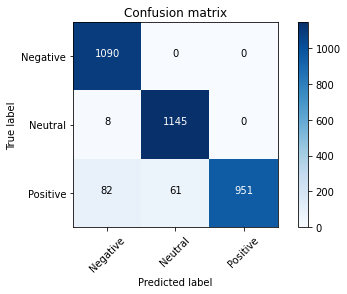

In [113]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

In [114]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      1090
           1       0.95      0.99      0.97      1153
           2       1.00      0.87      0.93      1094

    accuracy                           0.95      3337
   macro avg       0.96      0.95      0.95      3337
weighted avg       0.96      0.95      0.95      3337



> ROC-AUC curve

>  > This is a very important curve where we decide on which threshold to setup based upon the objective criteria. Here we plotted ROC for different classes which can help us understand which class was classified better. Also we plot micro and macro averages on the roc curve.

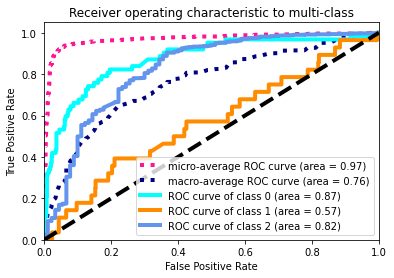

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Assuming y is already defined and contains your target labels
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Train-Test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Computing TPR and FPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])  # Changed to np.interp

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# END OF SCRIPTS